In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import os
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
plt.rcParams.update({'font.size': 20})

In [101]:
train_dir = 'Dataset/Training/'
test_dir = 'Dataset/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

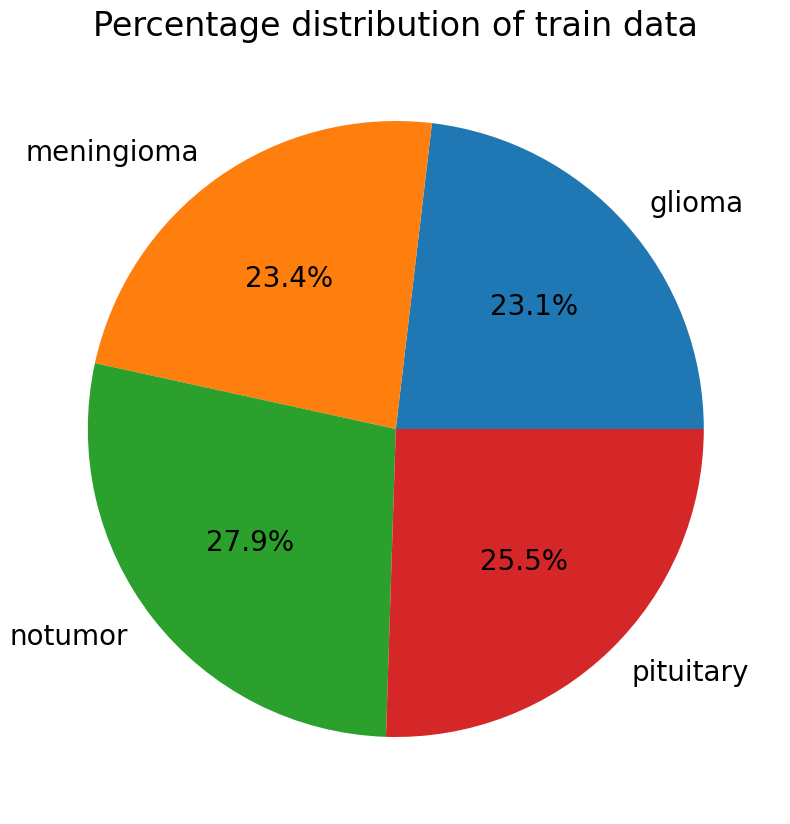

In [102]:
plt.figure(figsize=(10,10))
plt.pie(Counter(train_labels).values(), labels = Counter(train_labels).keys(), autopct='%.1f%%')
plt.title('Percentage distribution of train data')
plt.show() 

In [139]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

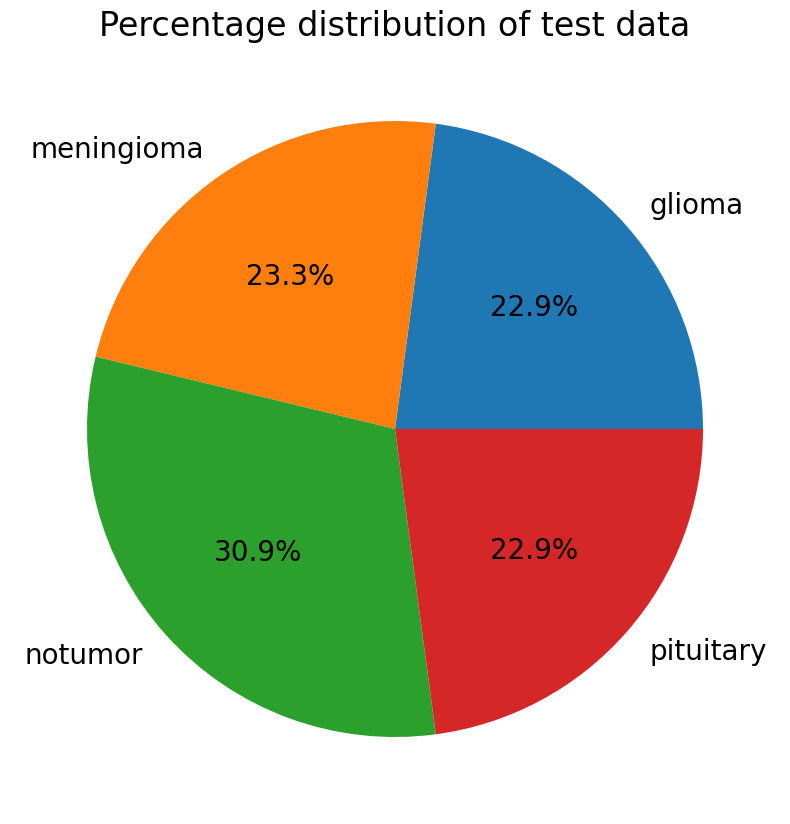

In [140]:
plt.figure(figsize=(10,10))
plt.pie(Counter(test_labels).values(), labels = Counter(test_labels).keys(), autopct='%.1f%%')
plt.title('Percentage distribution of test data')
plt.show() 

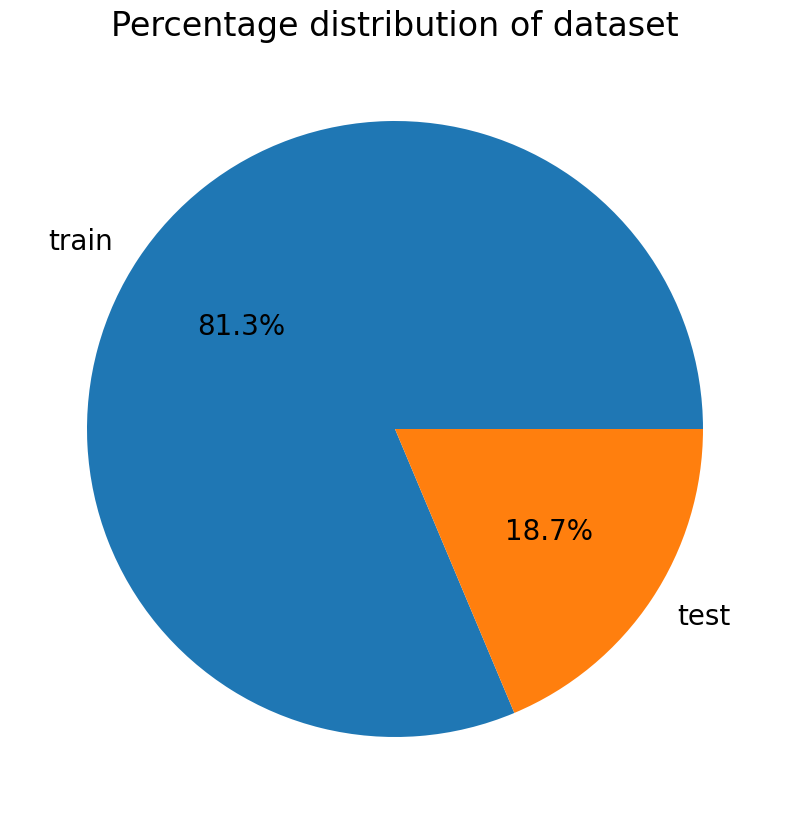

In [141]:
plt.figure(figsize=(10,10))
plt.pie([len(train_labels), len(test_labels)], labels = ['train', 'test'], autopct='%.1f%%')
plt.title('Percentage distribution of dataset')
plt.show() 

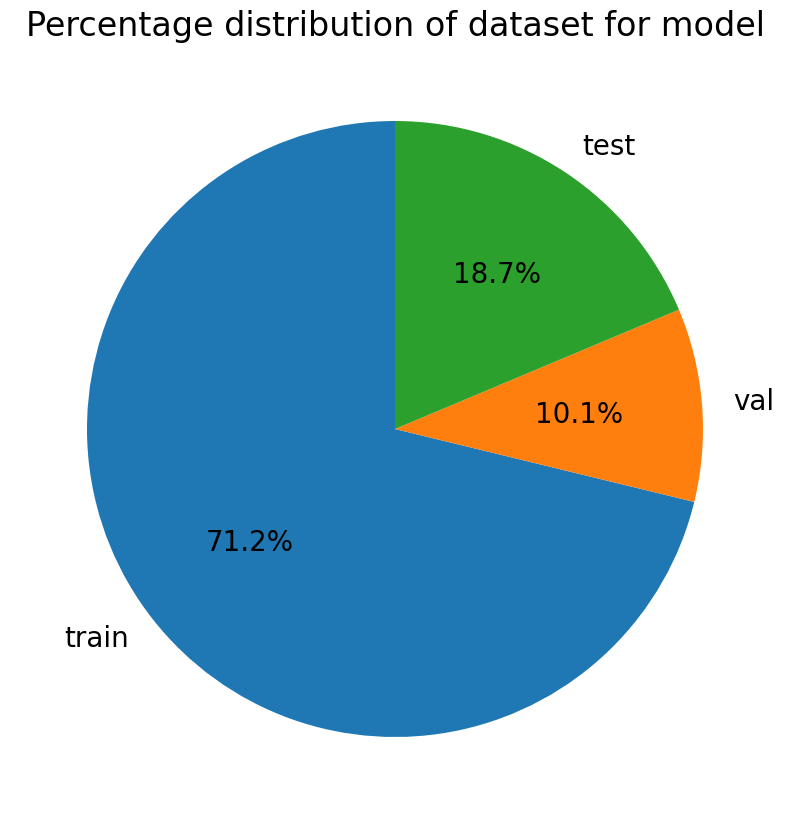

In [142]:
plt.figure(figsize=(10,10))
plt.pie([5000, 712, len(test_labels)], labels = ['train', 'val','test'], autopct='%.1f%%', startangle=90)
plt.title('Percentage distribution of dataset for model')
plt.show() 

In [143]:
class TumorDataset(Dataset):
    
    def __init__(self, train, transform=None):
        if train:
            self.dir = 'Dataset/Training/'
        else:
            self.dir = 'Dataset/Testing/'
        self.transform = transform
        self.labelinnum = {'glioma':0, 'meningioma':1, 'notumor':2, 'pituitary':3}
        self.paths = []
        self.labels = []

        for label in os.listdir(self.dir):
            for image in os.listdir(self.dir+label):
                self.paths.append(self.dir+label+'/'+image)
                self.labels.append(label)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image = Image.open(self.paths[index])
        if self.transform is not None:
            image = self.transform(image)    
        label = self.labelinnum[self.labels[index]]
        return image, label

In [144]:
train = TumorDataset(train=True, transform=transforms.Compose([transforms.Resize((512, 512)),transforms.Grayscale(), transforms.ToTensor()]))
test = TumorDataset(train=False, transform=transforms.Compose([transforms.Resize((512, 512)),transforms.Grayscale(), transforms.ToTensor()]))

train_set, val_set = torch.utils.data.random_split(train, [5000, 712])

In [145]:
batch_size=128
trainset = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
testset = DataLoader(dataset=test, batch_size=batch_size, shuffle=True)
valset = DataLoader(dataset=val_set, batch_size=len(val_set), shuffle=True)
trainloss = DataLoader(dataset=train_set, batch_size=len(train_set), shuffle=True)

In [146]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        
        # 1x1 conv branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        
        # 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )
        
        # pool branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=4):
        super(GoogLeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288,32, 64, 64)
    
        self.inception5a = Inception(528, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [147]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [148]:
def evaluate_accuracy(testset, net, device):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testset:
          X, y = data
          X = X.to(device)
          y = y.to(device)
          output = net(X)
          
          for idx, i in enumerate(output):
              if torch.argmax(i) == y[idx]:
                  correct += 1
              total += 1 
  return round(correct/total*100, 4) 

In [149]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 125 * 125, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 125 * 125)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [150]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = LeNet()
net.to(device)
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [155]:
def train(net, loss_f, optimizer, n_epoch=1):
    lossdata = []
    vallossdata = []
    acc=[]
    valacc=[]
    torch.cuda.empty_cache()
    for epoch in range(n_epoch):
        net.train()
        batch_idx = 0 
        for data in trainset:
            X, y = data
            X = X.to(device)
            y = y.to(device) 
            optimizer.zero_grad()  
            output = net(X)
            loss = loss_f(output, y)  

            # Backpropergation 
            loss.backward()  
            optimizer.step()

            batch_idx += 1
        net.eval()
        with torch.no_grad():
            for data in trainloss:
                x_t,y_t = data
                x_t = x_t.to(device)
                y_t = y_t.to(device) 
                lossdata.append(loss_f(net(x_t), y_t).item())
            for data in valset:
                x_t,y_t = data
                vallossdata.append(loss_f(net(x_t), y_t).item())
                
        acc.append(evaluate_accuracy(trainset, net, device))
        valacc.append(evaluate_accuracy(valset, net, device))
        print(f"Epoch: {epoch} Idx:{batch_idx}  Epoch Progress:{round(batch_idx/len(trainset)*100, 2)}%    Training Progress:{round((epoch*len(trainset)+batch_idx)/(n_epoch*len(trainset))*100,2)}%")    
    return lossdata, acc, vallossdata, valacc

In [156]:
n_epoch = 10
loss, acc = train(net, loss_criterion, optimizer, n_epoch)

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.84 GiB (GPU 0; 11.99 GiB total capacity; 5.83 GiB already allocated; 2.63 GiB free; 7.10 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [39]:
loss

[1.1920927533992653e-07,
 1.6093227941382793e-06,
 5.364415187614213e-07,
 1.7881390590446244e-07,
 0.0,
 6.55650637781946e-07,
 0.0,
 4.172323428974778e-07,
 4.172323428974778e-07,
 0.0]

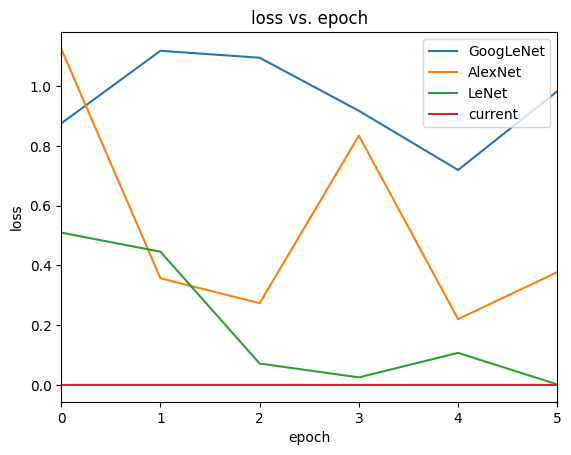

In [41]:
plt.plot(np.arange(n_epoch), x1, label = "GoogLeNet")
plt.plot(np.arange(n_epoch), x2, label = "AlexNet")
plt.plot(np.arange(n_epoch), x3, label = "LeNet")
plt.plot(np.arange(n_epoch), loss, label = "current")
plt.title("loss vs. epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xlim(0,5)
plt.legend()
plt.show()

In [42]:
correct = 0
total = 0
with torch.no_grad():
    for data in testset:
        X, y = data
        X = X.to(device)
        y = y.to(device)
        output = net(X)
        
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1 
round(correct/total*100, 4) 

94.1266

In [43]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainset:
        X, y = data
        X = X.to(device)
        y = y.to(device)
        output = net(X)
        
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1 
round(correct/total*100, 4) 

100.0